# Kampala Air Quality and TB Analysis - Simplified Pipeline

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Import simplified modules
import sys
sys.path.append('../src')

from simplified_data_processor import SimplifiedDataProcessor
from intervention_simulator import InterventionSimulator
from time_series_modeler import TimeSeriesModeler
from visualizer import Visualizer
from report_generator import ReportGenerator

# Set up plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All modules imported successfully")

✓ All modules imported successfully


In [3]:
# ## Step 1: Load and Process Data

# %%
# Initialize data processor
processor = SimplifiedDataProcessor(data_dir='../data')

# Load the merged data
data = processor.load_data('../data/final_data.csv')
print(f"✓ Loaded data: {len(data)} records")

INFO:simplified_data_processor:SimplifiedDataProcessor initialized with data directory: ..\data
INFO:simplified_data_processor:Loading data from ../data/final_data.csv
INFO:simplified_data_processor:Loaded 182 records
INFO:simplified_data_processor:Data processing complete: 182 records


✓ Loaded data: 182 records


In [4]:
# Add lag features and rolling averages
processed_data = processor.add_lag_features()
print(f"✓ Added features: {processed_data.shape[1]} total columns")


INFO:simplified_data_processor:Added lag features and rolling averages


✓ Added features: 42 total columns


In [5]:
# Get summary statistics
summary = processor.get_summary_statistics()
print("\nData Summary:")
print(f"- Date range: {summary['date_range']}")
print(f"- Average PM2.5: {summary['pm25_statistics']['mean']:.2f} μg/m³")
print(f"- Total TB cases: {summary['tb_statistics']['total_cases']}")
print(f"- PM2.5-TB correlation: {summary['correlation_pm25_tb']:.3f}")



Data Summary:
- Date range: 2021-01-04 00:00:00 to 2024-10-14 00:00:00
- Average PM2.5: 27.68 μg/m³
- Total TB cases: 9658
- PM2.5-TB correlation: -0.072


In [6]:
# Display first few rows
processed_data[['date', 'pm2_5', 'TB', 'avgtemp', 'avghumidity']].head(10)

,date,pm2_5,TB,avgtemp,avghumidity
0,2021-01-04,48.811054,38,22.9,78.4
1,2021-01-11,49.079578,17,22.2,81.5
2,2021-01-18,24.202109,30,22.8,79.6
3,2021-01-25,35.673026,38,23.1,78.7
4,2021-02-01,57.883441,40,23.8,74.3
5,2021-02-08,36.093051,47,23.4,77.7
6,2021-02-15,60.895662,45,23.2,73.5
7,2021-02-22,28.910818,29,23.3,78.9
8,2021-03-01,21.744544,35,24.3,75.7
9,2021-03-08,25.375573,30,23.8,76.0


## Step 2: Exploratory Data Analysis

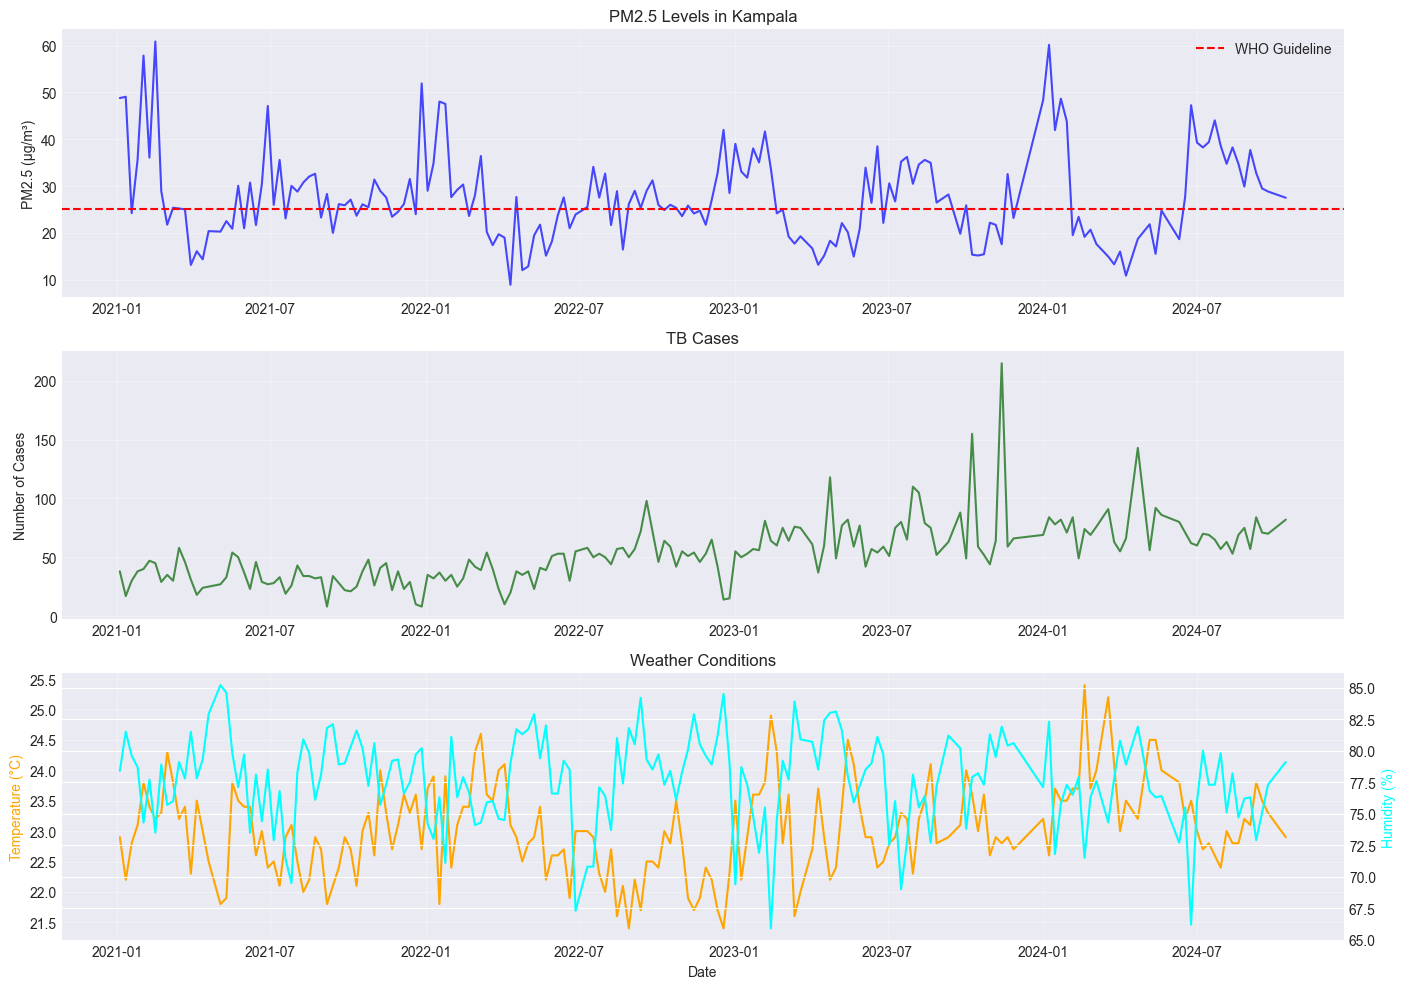

In [7]:
# Time series plot
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# PM2.5 over time
axes[0].plot(data['date'], data['pm2_5'], color='blue', alpha=0.7)
axes[0].axhline(y=25, color='red', linestyle='--', label='WHO Guideline')
axes[0].set_title('PM2.5 Levels in Kampala')
axes[0].set_ylabel('PM2.5 (μg/m³)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# TB cases over time
axes[1].plot(data['date'], data['TB'], color='darkgreen', alpha=0.7)
axes[1].set_title('TB Cases')
axes[1].set_ylabel('Number of Cases')
axes[1].grid(True, alpha=0.3)

# Temperature and humidity
ax2_twin = axes[2].twinx()
axes[2].plot(data['date'], data['avgtemp'], color='orange', label='Temperature')
ax2_twin.plot(data['date'], data['avghumidity'], color='cyan', label='Humidity')
axes[2].set_title('Weather Conditions')
axes[2].set_ylabel('Temperature (°C)', color='orange')
ax2_twin.set_ylabel('Humidity (%)', color='cyan')
axes[2].set_xlabel('Date')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

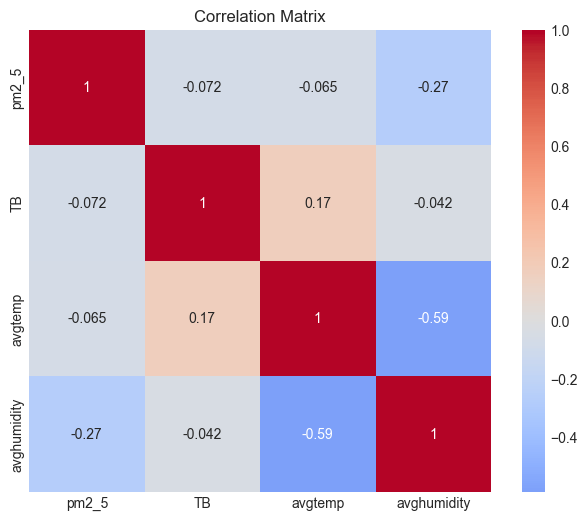

In [8]:
# Correlation analysis
correlation_vars = ['pm2_5', 'TB', 'avgtemp', 'avghumidity']
corr_matrix = data[correlation_vars].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix')
plt.show()


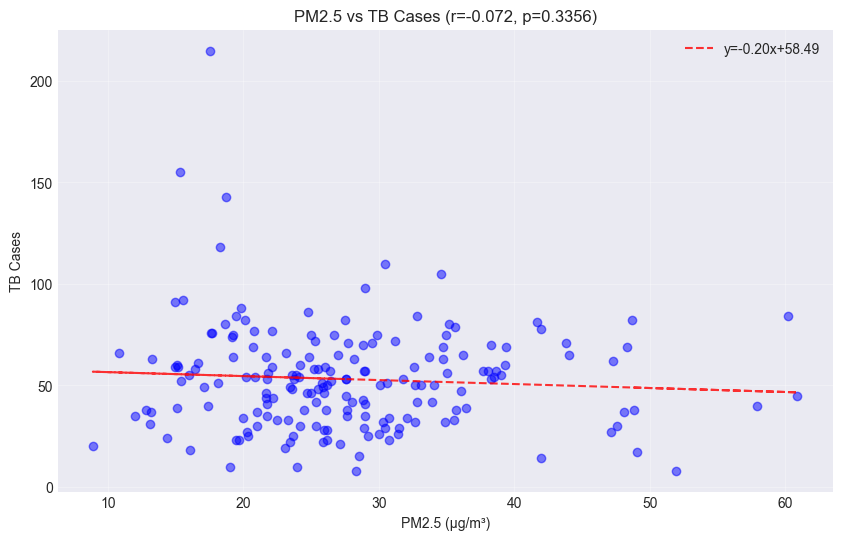

In [9]:
# PM2.5 vs TB scatter plot with regression line
import scipy.stats as stats

plt.figure(figsize=(10, 6))
plt.scatter(data['pm2_5'], data['TB'], alpha=0.5, color='blue')

# Add regression line
z = np.polyfit(data['pm2_5'], data['TB'], 1)
p = np.poly1d(z)
plt.plot(data['pm2_5'], p(data['pm2_5']), "r--", alpha=0.8, label=f'y={z[0]:.2f}x+{z[1]:.2f}')

# Calculate correlation
corr, p_value = stats.pearsonr(data['pm2_5'], data['TB'])
plt.title(f'PM2.5 vs TB Cases (r={corr:.3f}, p={p_value:.4f})')
plt.xlabel('PM2.5 (μg/m³)')
plt.ylabel('TB Cases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Step 3: Interrupted Time Series

In [10]:
# --- 1. Data Preprocessing ---

# Convert 'ds' to datetime and set as index
data_itsa = processed_data.copy()
data_itsa ['ds'] = pd.to_datetime(data['ds'], format='%d/%m/%Y')
data_itsa = data_itsa.sort_values('ds').set_index('ds')

In [11]:
# --- 2. Handle Missing Data ---

# Check for missing values before handling them
print("--- Missing Values Before Handling ---")
print(data_itsa.isnull().sum())

# Use forward fill to handle missing values, a common method for time series
data_itsa.fillna(method='ffill', inplace=True)

# Verify that missing values are handled
print("\n--- Missing Values After Forward Fill ---")
print(data.isnull().sum())


--- Missing Values Before Handling ---
pm2_5                   0
avgtemp                 0
avghumidity             0
year                    0
month                   0
week_of_year            0
TB                      0
date                    0
year_month              0
county                  0
avg_pm2_5_calibrated    0
total_tb                0
temperature             0
humidity                0
total_pneumonia         0
pm25_lag_1              1
tb_lag_1                1
temp_lag_1              1
humidity_lag_1          1
pm25_lag_2              2
tb_lag_2                2
temp_lag_2              2
humidity_lag_2          2
pm25_lag_3              3
tb_lag_3                3
temp_lag_3              3
humidity_lag_3          3
pm25_lag_4              4
tb_lag_4                4
temp_lag_4              4
humidity_lag_4          4
pm25_ma_7               0
tb_ma_7                 0
pm25_ma_14              0
tb_ma_14                0
pm25_ma_30              0
tb_ma_30                0

In [12]:
# --- 3. Define the Intervention Point ---

# Find the halfway point in the data
intervention_point = len(data_itsa) // 2
intervention_date = data_itsa.index[intervention_point]

print(f"\nThe dataset has {len(data_itsa)} data points.")
print(f"The intervention is set at index {intervention_point}, which corresponds to the date: {intervention_date.date()}")



The dataset has 182 data points.
The intervention is set at index 91, which corresponds to the date: 2022-10-17


In [13]:
# --- 4. Create Interrupted Time Series (ITS) Variables ---

# Time variable: a sequence from 1 to the number of observations
data_itsa['time'] = np.arange(1, len(data_itsa) + 1)

# Intervention variable: 0 before the intervention, 1 after
data_itsa['intervention'] = (data_itsa.index >= intervention_date).astype(int)

# Time since intervention: 0 before, and counts up from 1 after the intervention
data_itsa['time_since_intervention'] = 0
post_intervention_indices = data_itsa[data_itsa['intervention'] == 1].index
time_since_intervention_values = np.arange(len(post_intervention_indices))
data_itsa.loc[post_intervention_indices, 'time_since_intervention'] = time_since_intervention_values

In [14]:
# --- 5. Model Building ---

# Define dependent and independent variables
y = data_itsa['TB']
X = data_itsa[['time', 'intervention', 'time_since_intervention', 'pm2_5', 'avgtemp', 'avghumidity']]
X = sm.add_constant(X) # Add a constant (intercept) to the model

# Fit the Ordinary Least Squares (OLS) model
model = sm.OLS(y, X).fit()

# Print the model summary
print("\n--- Interrupted Time Series Model Summary ---")
print(model.summary())


--- Interrupted Time Series Model Summary ---
                            OLS Regression Results                            
Dep. Variable:                     TB   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     21.86
Date:                Wed, 27 Aug 2025   Prob (F-statistic):           4.15e-19
Time:                        17:43:37   Log-Likelihood:                -801.53
No. Observations:                 182   AIC:                             1617.
Df Residuals:                     175   BIC:                             1639.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------


Visualization saved as 'its_analysis_plot.png'


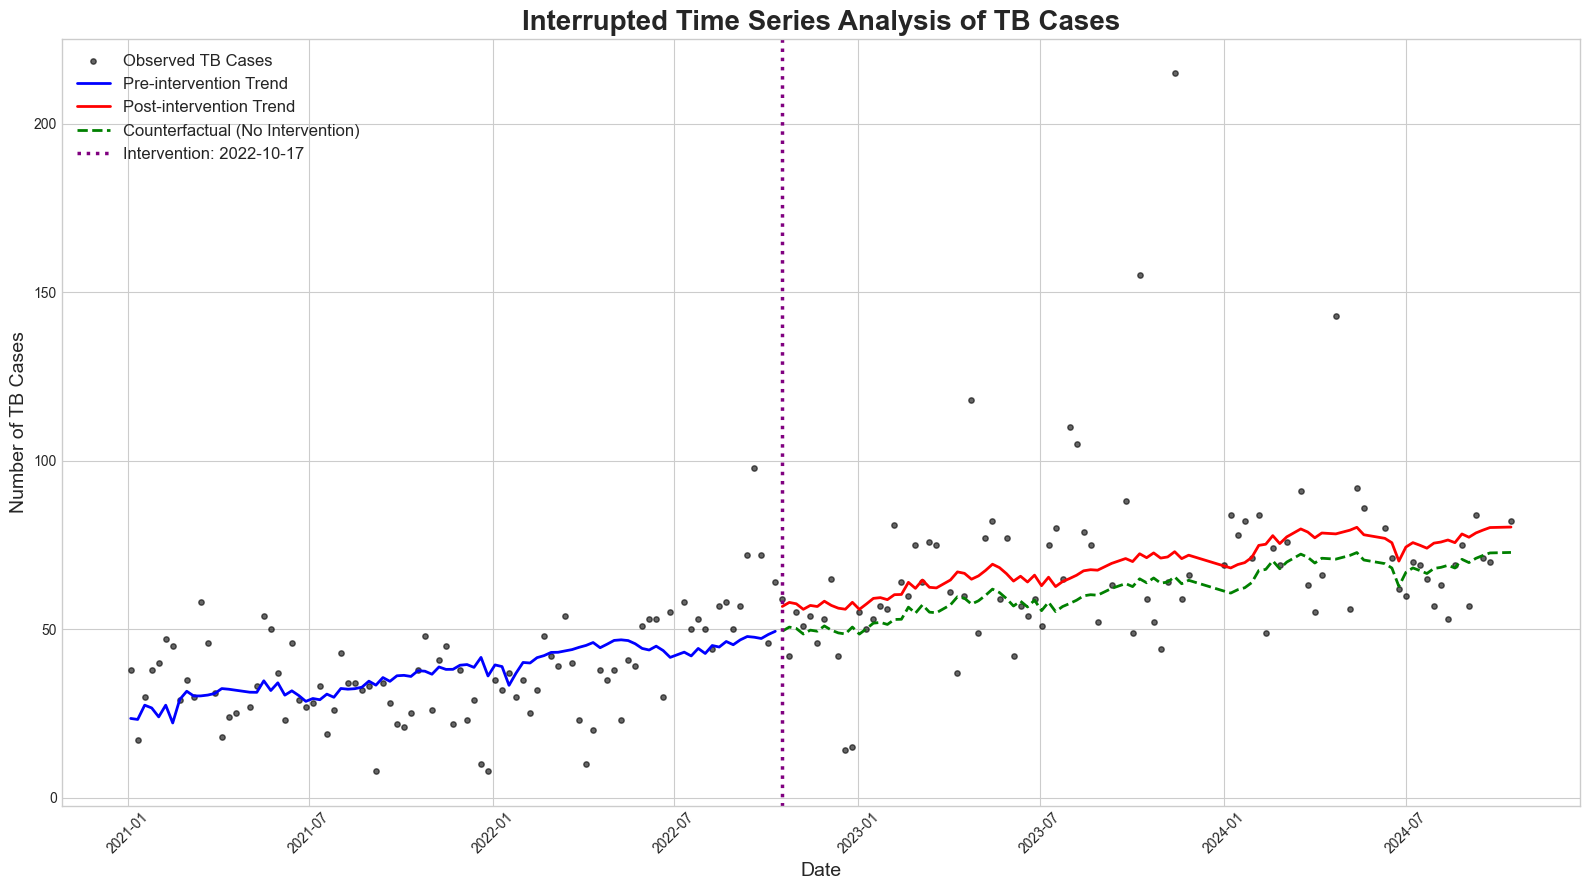

In [15]:
# --- 6. Advanced Visualization ---

# Generate predictions for the entire period
data_itsa['predicted_tb'] = model.predict(X)

# Generate a counterfactual prediction: what would have happened without the intervention?
X_counterfactual = X.copy()
X_counterfactual['intervention'] = 0
X_counterfactual['time_since_intervention'] = 0
data_itsa['counterfactual_tb'] = model.predict(X_counterfactual)

# Plotting the results
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 9))

# Plot the observed data
ax.scatter(data_itsa.index, data_itsa['TB'], color='black', alpha=0.6, label='Observed TB Cases', s=15)

# Plot the model's prediction for the pre-intervention period
pre_intervention_data = data_itsa[data_itsa['intervention'] == 0]
ax.plot(pre_intervention_data.index, pre_intervention_data['predicted_tb'], color='blue', linestyle='-', linewidth=2, label='Pre-intervention Trend')


# Plot the model's prediction for the post-intervention period
post_intervention_data = data_itsa[data_itsa['intervention'] == 1]
ax.plot(post_intervention_data.index, post_intervention_data['predicted_tb'], color='red', linestyle='-', linewidth=2, label='Post-intervention Trend')

# Plot the counterfactual
ax.plot(post_intervention_data.index, post_intervention_data['counterfactual_tb'], color='green', linestyle='--', linewidth=2, label='Counterfactual (No Intervention)')


# Highlight the intervention point
ax.axvline(x=intervention_date, color='purple', linestyle=':', linewidth=2.5, label=f'Intervention: {intervention_date.date()}')

# Formatting the plot
ax.set_title('Interrupted Time Series Analysis of TB Cases', fontsize=20, fontweight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Number of TB Cases', fontsize=14)
ax.legend(loc='upper left', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
plt.savefig('its_analysis_plot.png', dpi=300)

print("\nVisualization saved as 'its_analysis_plot.png'")

## Step 4: Seasonal Analysis

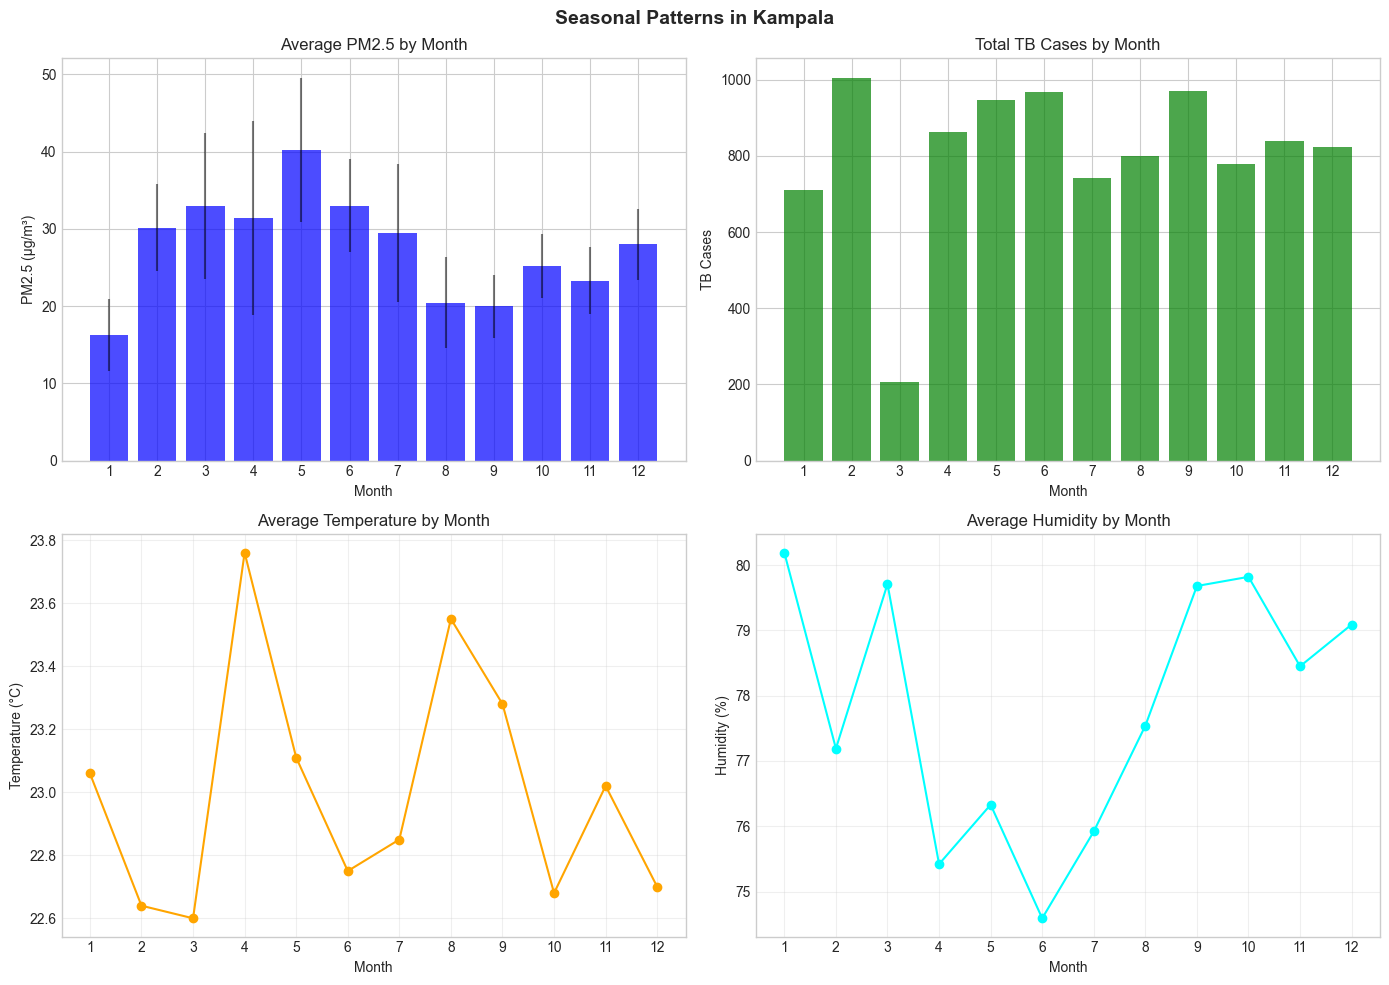

In [16]:

# Monthly patterns
monthly_stats = data.groupby('month').agg({
    'pm2_5': ['mean', 'std'],
    'TB': ['mean', 'sum'],
    'avgtemp': 'mean',
    'avghumidity': 'mean'
}).round(2)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# PM2.5 by month
axes[0, 0].bar(range(1, 13), monthly_stats['pm2_5']['mean'].values, color='blue', alpha=0.7)
axes[0, 0].errorbar(range(1, 13), monthly_stats['pm2_5']['mean'].values, 
                     yerr=monthly_stats['pm2_5']['std'].values, fmt='none', color='black', alpha=0.5)
axes[0, 0].set_title('Average PM2.5 by Month')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('PM2.5 (μg/m³)')
axes[0, 0].set_xticks(range(1, 13))

# TB cases by month
axes[0, 1].bar(range(1, 13), monthly_stats['TB']['sum'].values, color='green', alpha=0.7)
axes[0, 1].set_title('Total TB Cases by Month')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('TB Cases')
axes[0, 1].set_xticks(range(1, 13))

# Temperature pattern
axes[1, 0].plot(range(1, 13), monthly_stats['avgtemp']['mean'].values, 'o-', color='orange')
axes[1, 0].set_title('Average Temperature by Month')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Temperature (°C)')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].grid(True, alpha=0.3)

# Humidity pattern
axes[1, 1].plot(range(1, 13), monthly_stats['avghumidity']['mean'].values, 'o-', color='cyan')
axes[1, 1].set_title('Average Humidity by Month')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Humidity (%)')
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Seasonal Patterns in Kampala', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [17]:
data_project = processed_data.copy()
data_project = data_project[["ds", "TB"]]
data_project = data_project.rename(columns={"TB": "y"})
data_project['ds'] = pd.to_datetime(data_project['ds'], format='%d/%m/%Y')

In [18]:
m = Prophet()
m.fit(data_project)

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:Adding TBB (C:\Users\uthle\anaconda3\envs\MLearn3\Lib\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\uthle\AppData\Local\Temp\tmpoly617p6\b56hmt9p.json
DEBUG:cmdstanpy:input tempfile: C:\Users\uthle\AppData\Local\Temp\tmpoly617p6\axhtfye4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\uthle\\anaconda3\\envs\\mlearn3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=93078', 'data', 'file=C:\\Users\\uthle\\AppData\\Local\\Temp\\tmpoly617p6\\b56hmt9p.json', 'init=C:\\Users\\uthle\\AppData\\Local\\Temp\\tmpoly617p6\\axhtfye4.json', 'output', 'file=C:\

In [19]:
future = m.make_future_dataframe(periods=12 * 5,
                                 freq='M')

In [20]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower',
          'yhat_upper', 'trend',
          'trend_lower', 'trend_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
237,2029-05-31,157.415870,131.381735,180.212253,149.731131,147.839935,151.573665
238,2029-06-30,145.871548,121.729504,171.429833,150.927758,148.984860,152.811458
239,2029-07-31,154.750354,130.423874,177.085997,152.164272,150.169830,154.087638
240,2029-08-31,146.693440,121.537551,170.284989,153.400786,151.339889,155.371766
241,2029-09-30,162.421043,137.330196,185.364794,154.597413,152.475743,156.619194


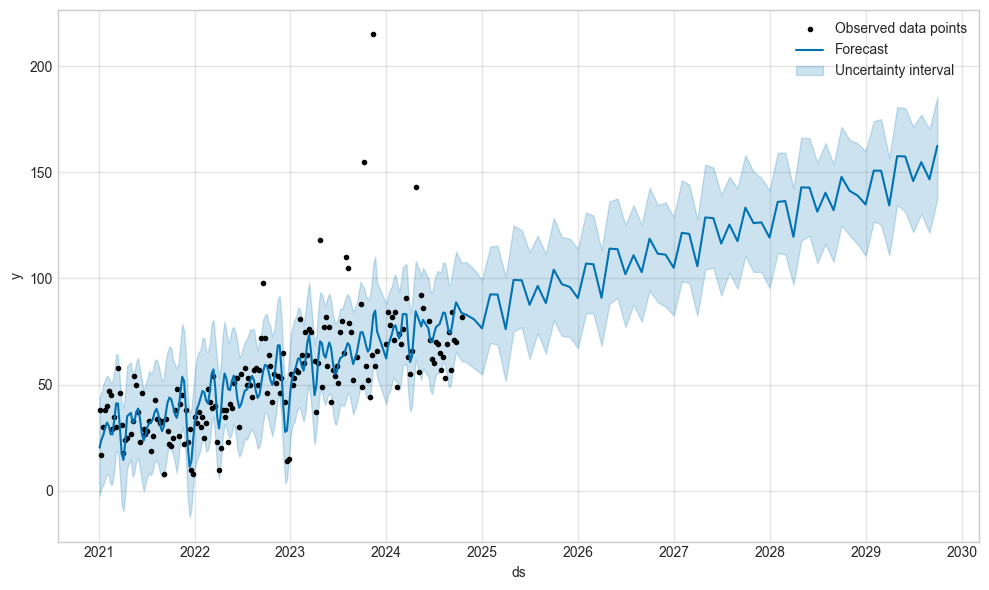

In [21]:
fig1 = m.plot(forecast, include_legend=True)

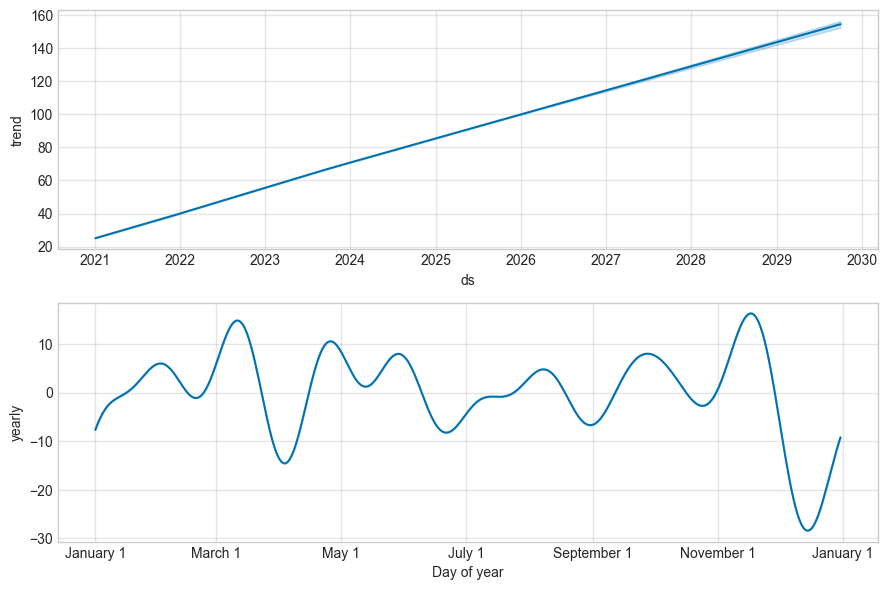

In [22]:
fig2 = m.plot_components(forecast)

## Step 5: Time Series Modeling

In [23]:
data_predict = processed_data.copy()

In [24]:
data_predict = pd.read_csv("../data/clean_data.csv")
data_predict = data_predict.drop(columns=["ds", 'total_tb','total_pneumonia',
                          'tb_lag_1','tb_lag_2','tb_lag_3','tb_lag_4',
                         'tb_ma_7', 'tb_ma_14', 'tb_ma_30','date'])

In [25]:
data_predict

,pm2_5,avgtemp,avghumidity,year,month,week_of_year,TB,year_month,county,avg_pm2_5_calibrated,...,pm25_lag_4,temp_lag_4,humidity_lag_4,pm25_ma_7,pm25_ma_14,pm25_ma_30,quarter,is_weekend,day_of_year,season
0,48.811054,22.9,78.4,2021,1,1,38,2021-01,Kampala,48.811054,...,NaN,NaN,NaN,48.811054,48.811054,48.811054,1,0,4,dry
1,49.079578,22.2,81.5,2021,1,2,17,2021-01,Kampala,49.079578,...,NaN,NaN,NaN,48.945316,48.945316,48.945316,1,0,11,dry
2,24.202109,22.8,79.6,2021,1,3,30,2021-01,Kampala,24.202109,...,NaN,NaN,NaN,40.697580,40.697580,40.697580,1,0,18,dry
3,35.673026,23.1,78.7,2021,1,4,38,2021-01,Kampala,35.673026,...,NaN,NaN,NaN,39.441442,39.441442,39.441442,1,0,25,dry
4,57.883441,23.8,74.3,2021,2,5,40,2021-02,Kampala,57.883441,...,48.811054,22.9,78.4,43.129842,43.129842,43.129842,1,0,32,dry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,37.709048,23.1,76.3,2024,9,36,57,2024-09,Kampala,37.709048,...,34.754049,23.0,75.1,36.866512,35.247193,29.988052,3,0,246,wet
178,32.803703,23.8,72.9,2024,9,37,84,2024-09,Kampala,32.803703,...,38.260420,22.8,78.2,35.260292,35.821227,29.075782,3,0,253,wet
179,29.487460,23.5,75.1,2024,9,38,71,2024-09,Kampala,29.487460,...,34.761316,22.8,74.7,33.954740,36.595509,28.660047,3,0,260,wet
180,28.838261,23.3,77.3,2024,9,39,70,2024-09,Kampala,28.838261,...,29.907184,23.2,76.2,33.109627,36.672499,27.998851,3,0,267,wet


In [26]:
data_predict

,pm2_5,avgtemp,avghumidity,year,month,week_of_year,TB,year_month,county,avg_pm2_5_calibrated,...,pm25_lag_4,temp_lag_4,humidity_lag_4,pm25_ma_7,pm25_ma_14,pm25_ma_30,quarter,is_weekend,day_of_year,season
0,48.811054,22.9,78.4,2021,1,1,38,2021-01,Kampala,48.811054,...,NaN,NaN,NaN,48.811054,48.811054,48.811054,1,0,4,dry
1,49.079578,22.2,81.5,2021,1,2,17,2021-01,Kampala,49.079578,...,NaN,NaN,NaN,48.945316,48.945316,48.945316,1,0,11,dry
2,24.202109,22.8,79.6,2021,1,3,30,2021-01,Kampala,24.202109,...,NaN,NaN,NaN,40.697580,40.697580,40.697580,1,0,18,dry
3,35.673026,23.1,78.7,2021,1,4,38,2021-01,Kampala,35.673026,...,NaN,NaN,NaN,39.441442,39.441442,39.441442,1,0,25,dry
4,57.883441,23.8,74.3,2021,2,5,40,2021-02,Kampala,57.883441,...,48.811054,22.9,78.4,43.129842,43.129842,43.129842,1,0,32,dry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,37.709048,23.1,76.3,2024,9,36,57,2024-09,Kampala,37.709048,...,34.754049,23.0,75.1,36.866512,35.247193,29.988052,3,0,246,wet
178,32.803703,23.8,72.9,2024,9,37,84,2024-09,Kampala,32.803703,...,38.260420,22.8,78.2,35.260292,35.821227,29.075782,3,0,253,wet
179,29.487460,23.5,75.1,2024,9,38,71,2024-09,Kampala,29.487460,...,34.761316,22.8,74.7,33.954740,36.595509,28.660047,3,0,260,wet
180,28.838261,23.3,77.3,2024,9,39,70,2024-09,Kampala,28.838261,...,29.907184,23.2,76.2,33.109627,36.672499,27.998851,3,0,267,wet


In [27]:

# Split using row index
train = data_predict.iloc[:144]   # first 144 rows
test  = data_predict.iloc[144:]   # remaining rows

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (144, 31)
Test shape: (38, 31)


In [28]:
# import the regression module**
from pycaret.regression import *


In [29]:
# initialize setup**
s = setup(data = train, test_data = test, 
          target = 'TB', fold_strategy = 'timeseries', 
         fold = 3, transform_target = True, 
          data_split_shuffle=False, data_split_stratify=False,
          session_id = 123)

,Description,Value
0,Session id,123
1,Target,TB
2,Target type,Regression
3,Original data shape,"(182, 31)"
4,Transformed data shape,"(182, 31)"
5,Transformed train set shape,"(144, 31)"
6,Transformed test set shape,"(38, 31)"
7,Numeric features,27
8,Categorical features,3
9,Rows with missing values,2.2%


In [30]:
best = compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
par,Passive Aggressive Regressor,11.7797,287.1336,16.1314,0.0128,0.3492,0.3087,0.0433
catboost,CatBoost Regressor,19.8462,703.7363,24.2298,-1.1507,0.5125,0.4036,1.0367
et,Extra Trees Regressor,20.0285,705.4176,24.4356,-1.1980,0.5180,0.4110,0.0900
br,Bayesian Ridge,20.0438,706.0932,24.3841,-1.2076,0.5152,0.4044,0.0467
llar,Lasso Least Angle Regression,20.0734,716.3093,24.3518,-1.1632,0.5087,0.3984,1.3500
lasso,Lasso Regression,20.0878,716.4843,24.3580,-1.1644,0.5089,0.3992,1.5000
en,Elastic Net,20.1870,718.9882,24.4602,-1.1857,0.5106,0.3990,1.4733
ada,AdaBoost Regressor,20.3970,737.6923,24.6074,-1.1972,0.5258,0.4148,0.0667
omp,Orthogonal Matching Pursuit,20.4790,732.6418,24.7250,-1.2666,0.5189,0.4005,0.0467
gbr,Gradient Boosting Regressor,20.5933,739.2515,25.0679,-1.3230,0.5419,0.4211,0.0800


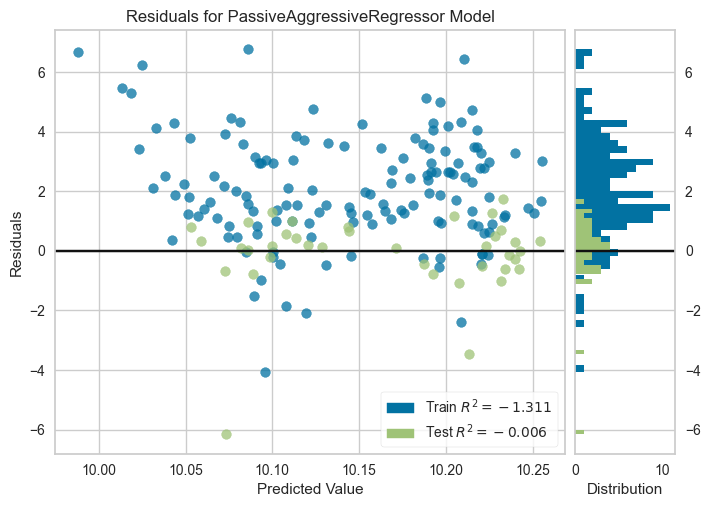

In [31]:
# plot residuals
plot_model(best, plot = 'residuals')

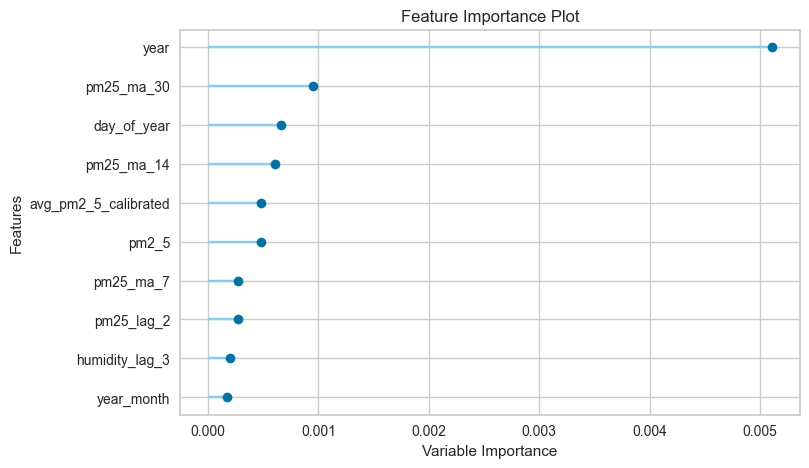

In [32]:
# plot feature importance
plot_model(best, plot = 'feature')

In [33]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## Step 4: Intervention Simulation

In [34]:
# Get baseline metrics
baseline = processor.get_intervention_baseline()
print("Baseline Metrics:")
print(f"- Average PM2.5: {baseline['baseline_pm25']:.2f} μg/m³")
print(f"- Average TB cases: {baseline['baseline_tb']:.2f}")
print(f"- Total TB cases: {baseline['total_tb_cases']}")


Baseline Metrics:
- Average PM2.5: 27.68 μg/m³
- Average TB cases: 53.07
- Total TB cases: 9658


In [35]:
# Simulate intervention scenarios
scenarios = {
    'Traffic Control': {'reduction': 0.25, 'cost_factor': 2.5},
    'Green Spaces': {'reduction': 0.15, 'cost_factor': 3.0},
    'Dust Control': {'reduction': 0.20, 'cost_factor': 4.0},
    'Combined': {'reduction': 0.35, 'cost_factor': 5.0}
}

# Calculate impact for each scenario
# Using concentration-response function for TB: 8% increase per 10 μg/m³
cr_tb = 1.08  # Relative risk per 10 μg/m³

results = []
for scenario_name, params in scenarios.items():
    # Calculate PM2.5 after intervention
    reduced_pm25 = baseline['baseline_pm25'] * (1 - params['reduction'])
    pm25_change = reduced_pm25 - baseline['baseline_pm25']
    
    # Calculate TB cases prevented using concentration-response function
    relative_risk = cr_tb ** (pm25_change / 10)
    tb_cases_baseline = baseline['total_tb_cases']
    tb_cases_with_intervention = tb_cases_baseline * relative_risk
    tb_cases_prevented = tb_cases_baseline - tb_cases_with_intervention
    
    # Calculate cost-effectiveness
    cost = params['cost_factor'] * 1000000  # Assume base cost of $1M
    cost_per_case = cost / tb_cases_prevented if tb_cases_prevented > 0 else float('inf')
    
    results.append({
        'Scenario': scenario_name,
        'PM2.5 Reduction (%)': params['reduction'] * 100,
        'Final PM2.5 (μg/m³)': reduced_pm25,
        'TB Cases Prevented': tb_cases_prevented,
        'Cost Factor': params['cost_factor'],
        'Cost per Case Prevented ($)': cost_per_case
    })

results_df = pd.DataFrame(results)
print("\nIntervention Simulation Results:")
print(results_df.to_string(index=False))



Intervention Simulation Results:
       Scenario  PM2.5 Reduction (%)  Final PM2.5 (μg/m³)  TB Cases Prevented  Cost Factor  Cost per Case Prevented ($)
Traffic Control                 25.0            20.757296          500.836361          2.5                  4991.650352
   Green Spaces                 15.0            23.524935          303.696306          3.0                  9878.289406
   Dust Control                 20.0            22.141116          402.791215          4.0                  9930.703178
       Combined                 35.0            17.989656          693.821730          5.0                  7206.462093


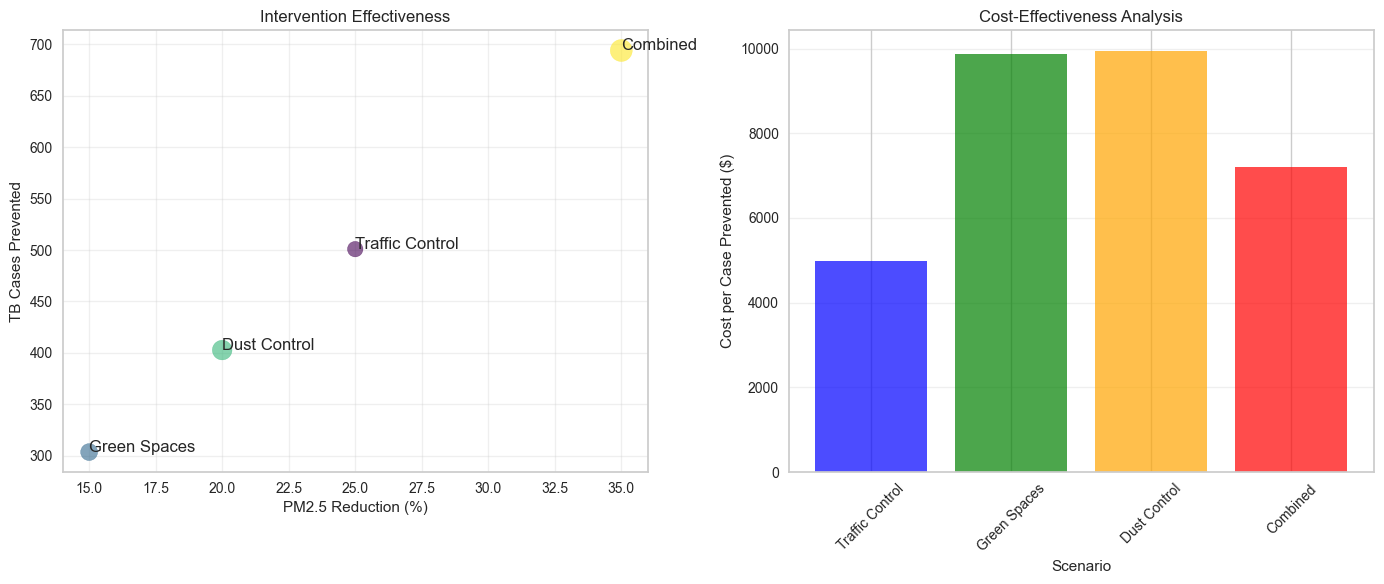

In [36]:
# Visualize intervention impacts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PM2.5 reduction vs cases prevented
axes[0].scatter(results_df['PM2.5 Reduction (%)'], 
                results_df['TB Cases Prevented'],
                s=results_df['Cost Factor']*50,
                alpha=0.6, c=range(len(results_df)), cmap='viridis')
for i, txt in enumerate(results_df['Scenario']):
    axes[0].annotate(txt, (results_df['PM2.5 Reduction (%)'].iloc[i], 
                           results_df['TB Cases Prevented'].iloc[i]))
axes[0].set_xlabel('PM2.5 Reduction (%)')
axes[0].set_ylabel('TB Cases Prevented')
axes[0].set_title('Intervention Effectiveness')
axes[0].grid(True, alpha=0.3)

# Cost-effectiveness
axes[1].bar(results_df['Scenario'], results_df['Cost per Case Prevented ($)'], 
           color=['blue', 'green', 'orange', 'red'], alpha=0.7)
axes[1].set_xlabel('Scenario')
axes[1].set_ylabel('Cost per Case Prevented ($)')
axes[1].set_title('Cost-Effectiveness Analysis')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## Step 6: Generate Report

In [37]:
# Summary Report
print("=" * 60)
print("KAMPALA AIR QUALITY AND TB ANALYSIS - SUMMARY REPORT")
print("=" * 60)
print()
print("1. DATA OVERVIEW")
print("-" * 40)
print(f"   - Analysis Period: {summary['date_range']}")
print(f"   - Total Records: {summary['total_records']}")
print(f"   - Average PM2.5: {summary['pm25_statistics']['mean']:.2f} μg/m³")
print(f"   - Total TB Cases: {summary['tb_statistics']['total_cases']}")
print()
print("2. KEY FINDINGS")
print("-" * 40)
print(f"   - PM2.5-TB Correlation: {summary['correlation_pm25_tb']:.3f}")
print(f"   - PM2.5 exceeds WHO guideline by {summary['pm25_statistics']['mean'] - 25:.1f} μg/m³")
print(f"   - Seasonal variation observed in both PM2.5 and TB cases")
print()
print("3. INTERVENTION RECOMMENDATIONS")
print("-" * 40)
best_scenario = results_df.loc[results_df['TB Cases Prevented'].idxmax()]
print(f"   - Most Effective: {best_scenario['Scenario']}")
print(f"   - PM2.5 Reduction: {best_scenario['PM2.5 Reduction (%)']:.1f}%")
print(f"   - TB Cases Prevented: {best_scenario['TB Cases Prevented']:.0f}")
print()
print("4. MODEL PERFORMANCE")
print("-" * 40)
best_model = models_performance.loc[models_performance['R² Score'].idxmax()]
print(f"   - Best Model: {best_model['Model']}")
print(f"   - R² Score: {best_model['R² Score']:.3f}")
print(f"   - MAE: {best_model['MAE']:.2f}")
print()
print("=" * 60)

# %%
# Save results
results_df.to_csv('../results/intervention_scenarios.csv', index=False)
models_performance.to_csv('../results/model_performance.csv', index=False)
feature_importance.to_csv('../results/feature_importance.csv', index=False)
print("✓ Results saved to ../results/ directory")

KAMPALA AIR QUALITY AND TB ANALYSIS - SUMMARY REPORT

1. DATA OVERVIEW
----------------------------------------
   - Analysis Period: 2021-01-04 00:00:00 to 2024-10-14 00:00:00
   - Total Records: 182
   - Average PM2.5: 27.68 μg/m³
   - Total TB Cases: 9658

2. KEY FINDINGS
----------------------------------------
   - PM2.5-TB Correlation: -0.072
   - PM2.5 exceeds WHO guideline by 2.7 μg/m³
   - Seasonal variation observed in both PM2.5 and TB cases

3. INTERVENTION RECOMMENDATIONS
----------------------------------------
   - Most Effective: Combined
   - PM2.5 Reduction: 35.0%
   - TB Cases Prevented: 694

4. MODEL PERFORMANCE
----------------------------------------


NameError: name 'models_performance' is not defined